#Experiments S
This notebook includes the code to recreate the experiments Mean LS, Reduced Set and Batch position

Part 1, basic setup

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Choose CIFAR-10 or CIFAR-100
dataset_name = 'CIFAR10'  # or 'CIFAR100'

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Data augmentation and normalization
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Split the dataset into num_tasks subsets. NEED DEVISIBLE BY 10/100
num_tasks = 5

# Load training and testing datasets
if dataset_name == 'CIFAR10':
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    num_classes = 10
    classes_per_subset = num_classes // num_tasks
elif dataset_name == 'CIFAR100':
    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
    num_classes = 100
    classes_per_subset = num_classes // num_tasks

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def split_dataset_by_classes(dataset, classes):
    """
    Split the dataset to only include samples from the specified classes.
    Args:
        dataset: The CIFAR-10 dataset object.
        classes: A list of class indices to include in the subset (e.g., [0, 1, 2]).
    Returns:
        A Subset containing only the samples from the specified classes.
    """
    targets = torch.tensor(dataset.targets)  # Get all labels as a tensor
    # Use `torch.isin` to check if each target is in the `classes` list
    indices = torch.where(torch.isin(targets, torch.tensor(classes)))[0]
    return Subset(dataset, indices)


# Create subsets for all pairs of casses
classes_list = list(range(0, num_classes))
class_pairs = [tuple(classes_list[i:i+classes_per_subset]) for i in range(0, len(classes_list), classes_per_subset)]  # Class pairs (e.g., (0, 1), (2, 3), ...)
train_subsets = {pair: split_dataset_by_classes(train_dataset, pair) for pair in class_pairs}
test_subsets = {pair: split_dataset_by_classes(test_dataset, pair) for pair in class_pairs}

# Example: Access a specific subset
# subset_0_1 = subsets[(0, 1)]
# print(f"Subset for classes {0, 1} size: {len(subset_0_1)}")

In [4]:
# Modify ResNet18 for CIFAR
class ResNet18ForCIFAR(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18ForCIFAR, self).__init__()
        self.model = resnet18(weights=None)  # Initialize ResNet18
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for CIFAR
        self.model.maxpool = nn.Identity()  # Remove max pooling layer
        self.model.fc = nn.Linear(512, num_classes)  # Adjust the final layer for CIFAR

    def forward(self, x):
        return self.model(x)

# Create model instance
model = ResNet18ForCIFAR(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [6]:
#changed this
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    total_num_samples = len(train_loader.dataset)
    is_correct = torch.zeros((1, total_num_samples))
    is_correct_idx = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Training]", leave=False)
    for batch_idx, (indexes,(inputs, targets)) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.shape[0]
        correct += predicted.eq(targets).sum().item()

        batch_num_samples = targets.shape[0]
        is_correct[:, indexes] = predicted.eq(targets).cpu().float()
        

        # Update progress bar
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")


    accuracy = 100. * correct / total
    return total_loss / len(train_loader), accuracy, is_correct

In [7]:
def test(model, test_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    # Wrap DataLoader with tqdm
    progress_bar = tqdm(test_loader, desc=f"Epoch {epoch} [Testing]", leave=False)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()

            # Update progress bar with batch loss and accuracy
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")

    accuracy = 100. * correct / total
    return total_loss / len(test_loader), accuracy

In [8]:
#changed this
num_epochs = 10
save_per_epochs = 20
per_task_learning_speed = torch.zeros(num_tasks,10000)

for task in range(num_tasks):
    train_subset = list(enumerate(train_subsets[class_pairs[task]]))
    test_subset = test_subsets[class_pairs[task]]
    train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=128, shuffle=False, num_workers=4)
    
    # For learning speed tracking
    total_num_samples = len(train_loader.dataset)
    M = torch.zeros((num_epochs, total_num_samples))
    
    print(f"Training task {task}...")
    for epoch in range(num_epochs):
      train_loss, train_acc, is_correct = train(model, train_loader, criterion, optimizer, device, epoch)
      M[epoch] = is_correct
      test_loss, test_acc = test(model, test_loader, criterion, device, epoch)
      scheduler.step()
    
      print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
      if epoch + 1 % save_per_epochs == 0:
        torch.save(model.state_dict(), f'resnet18_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        torch.save(optimizer.state_dict(), f'optimizer_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        torch.save(scheduler.state_dict(), f'scheduler_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        torch.save(M, f'M_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        print(f"Model of task {task} saved at epoch {epoch}.")

Training task 0...


KeyboardInterrupt: 

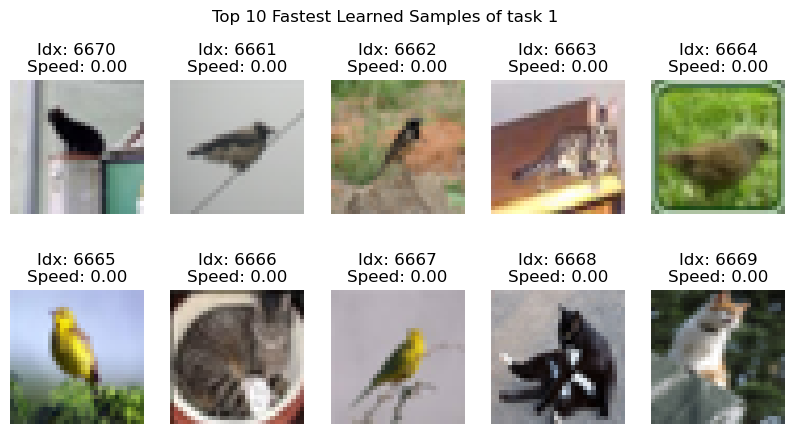

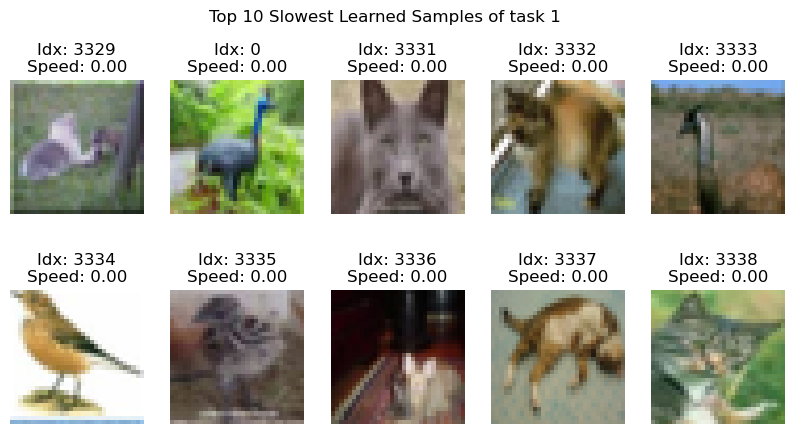

In [9]:
task = 1 # TODO: change this to visualize different tasks
# M = torch.load(f'M_{dataset_name.lower()}_task{task}_epoch{num_epochs-1}.pth')
learning_speed = M.sum(axis=0)
sorted_learning_speed, sorted_indices = torch.sort(learning_speed, descending=True)

top10_indices = sorted_indices[:10]
bottom10_indices = sorted_indices[-10:]

# Revert normalization for visualization
def denormalize(image, mean, std):
    # Reverse the normalization: (image * std) + mean
    for c in range(3):  # For each channel
        image[c] = image[c] * std[c] + mean[c]
    return image

# Function to visualize images
def visualize_samples(indices, title):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        img, _ = train_subsets[class_pairs[task]][idx]
        img = denormalize(img.clone(), mean, std)
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Idx: {idx}\nSpeed: {learning_speed[idx]:.2f}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize Top 10 fastest learned samples
visualize_samples(top10_indices, f"Top 10 Fastest Learned Samples of task {task}")

# Visualize Top 10 slowest learned samples
visualize_samples(bottom10_indices, f"Top 10 Slowest Learned Samples of task {task}")

Part 2 experiments:
compute the baseline learning speeds first

In [10]:
#create new model instance
model = ResNet18ForCIFAR(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


num_epochs = 10
save_per_epochs = 20
all_samples_learning_speed = torch.zeros(num_tasks,int(50000/num_tasks))

for task in range(num_tasks):
    train_subset = list(enumerate(train_subsets[class_pairs[task]]))
    test_subset = test_subsets[class_pairs[task]]
    train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=128, shuffle=False, num_workers=4)
    
    # For learning speed tracking
    total_num_samples = len(train_loader.dataset)
    M = torch.zeros((num_epochs, total_num_samples))
    
    print(f"Training task {task}...")
    for epoch in range(num_epochs):
      train_loss, train_acc, is_correct = train(model, train_loader, criterion, optimizer, device, epoch)
      M[epoch] = is_correct
      test_loss, test_acc = test(model, test_loader, criterion, device, epoch)
      scheduler.step()
    
      print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
      if epoch + 1 % save_per_epochs == 0:
        torch.save(model.state_dict(), f'resnet18_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        torch.save(optimizer.state_dict(), f'optimizer_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        torch.save(scheduler.state_dict(), f'scheduler_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        torch.save(M, f'M_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
        print(f"Model of task {task} saved at epoch {epoch}.")
    all_samples_learning_speed[task] = M.sum(axis=0)

Training task 0...


KeyboardInterrupt: 

Experiment Mean LS:

In [11]:
class avg_loader():
    def __init__(self,dataset,learning_speed,batch_size,tolerance = 0.1):
        self.length = int(len(dataset)/batch_size)
        self.dataset = dataset
        self.learning_speed = learning_speed
        self.batch_size = batch_size
        self.mean = torch.mean(self.learning_speed)
        print(self.mean)
        self.tolerance = tolerance
    def __iter__(self):
        self.dataset_ls = self.learning_speed
        self.dataset_X = torch.stack([x for (_,(x,_)) in self.dataset])
        self.dataset_y = torch.tensor([y for (_,(_,y)) in self.dataset])
        self.dataset_i = torch.tensor([i for (i,_) in self.dataset])
        for i in range(self.length):
            yield self.avg_batch()

    def __next__(self):
        return self.avg_batch()

    def __len__(self):
        return self.length
        
    def avg_batch(self):
        if len(self.dataset_X) <= 0:
            print('dataset empty')
            return None
        if len(self.dataset_X) <= self.batch_size:
            batch = (self.dataset_i,(self.dataset_X,self.dataset_y))
            self.dataset_X = None
            self.dataset_y = None
            self.dataset_i = None
            self.dataset_ls = None
            return batch
        for i in range(10):
            perm = torch.randperm(len(self.dataset_X))
            indxs = perm[:self.batch_size]
            not_indxs = perm[self.batch_size:]
            batch_mean = torch.mean(self.dataset_ls[indxs])
            
            if batch_mean <= self.mean + self.tolerance and batch_mean >= self.mean - self.tolerance:
                batch = (self.dataset_i[indxs],(self.dataset_X[indxs],self.dataset_y[indxs]))
                self.dataset_X = self.dataset_X[not_indxs]
                self.dataset_y = self.dataset_y[not_indxs]
                self.dataset_i = self.dataset_i[not_indxs]
                self.dataset_ls = self.dataset_ls[not_indxs]
                return batch
        print(f'No batch found within tolerance range, returning batch with mean {batch_mean}, dataset mean is {self.mean}')
        batch = (self.dataset_i[indxs],(self.dataset_X[indxs],self.dataset_y[indxs]))
        self.dataset_X = self.dataset_X[not_indxs]
        self.dataset_y = self.dataset_y[not_indxs]
        self.dataset_i = self.dataset_i[not_indxs]
        self.dataset_ls = self.dataset_ls[not_indxs]
        return batch
                

In [12]:
def run_exp(perm,exp_name):
    for run_index in range(5):
        model = ResNet18ForCIFAR(num_classes)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        
        
        num_epochs = 10
        save_per_epochs = 20
        all_samples_learning_speed_batch_avg = torch.zeros(num_tasks,int(50000/num_tasks))
        
        for task in perm:
            train_subset = list(enumerate(train_subsets[class_pairs[task]]))
            test_subset = test_subsets[class_pairs[task]]
            train_loader = avg_loader(dataset=train_subset,learning_speed = all_samples_learning_speed[task],batch_size = 128)
            test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=128, shuffle=False, num_workers=4)
            
            # For learning speed tracking
            total_num_samples = len(train_subset)
            M = torch.zeros((num_epochs, total_num_samples))
            
            print(f"Training task {task}...")
            for epoch in range(num_epochs):
              train_loss, train_acc, is_correct = train(model, train_loader, criterion, optimizer, device, epoch)
              M[epoch] = is_correct
              test_loss, test_acc = test(model, test_loader, criterion, device, epoch)
              scheduler.step()
            
              print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
              if epoch + 1 % save_per_epochs == 0:
                torch.save(model.state_dict(), f'resnet18_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                torch.save(optimizer.state_dict(), f'optimizer_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                torch.save(scheduler.state_dict(), f'scheduler_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                torch.save(M, f'M_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                print(f"Model of task {task} saved at epoch {epoch}.")
            all_samples_learning_speed_batch_avg[task] = M.sum(axis=0)
        torch.save(all_samples_learning_speed_batch_avg,f'first_exp/ls_{exp_name}_run{run_index}.pt')

In [13]:
exp_permutations = [[0,1,2,3,4],[4,3,1,2,0],[1,4,3,0,2],[3,2,0,4,1],[2,0,4,1,3]]
exp_names = ['p0','p1','p2','p3','p4']
for p,n in zip(exp_permutations,exp_names):
    run_exp(p,n)

tensor(0.)
Training task 0...


KeyboardInterrupt: 

Experiment Reduced set: 

In [14]:
import numpy as np

def top_percent_indices(arr,percentile):
    # Convert the array to a NumPy array
    arr = np.array(arr)
    
    # Calculate the number of elements to include in the top 20%
    num_elements = int(np.ceil(percentile * len(arr)))
    
    # Get the indices of the sorted array
    sorted_indices = np.argsort(-arr)
    
    # Select the top % indices
    top_indices = sorted_indices[:num_elements]
    
    return top_indices

def bot_percent_indices(arr,percentile):
    # Convert the array to a NumPy array
    arr = np.array(arr)
    
    # Calculate the number of elements to include in the top 20%
    num_elements = int(np.ceil(percentile * len(arr)))
    
    # Get the indices of the sorted array
    sorted_indices = np.argsort(arr)
    
    # Select the bot % indices
    top_indices = sorted_indices[:num_elements]
    
    return top_indices


def remove_top_bot(dataset,learning_speeds,percentile = 0.2):
    dataset_X = torch.stack([x for (_,(x,_)) in dataset])
    dataset_y = torch.tensor([y for (_,(_,y)) in dataset])
    dataset_i = torch.tensor([i for (i,_) in dataset])
    mask = np.ones(len(dataset), dtype=bool)
    top = top_percent_indices(learning_speeds,percentile)
    bot = bot_percent_indices(learning_speeds,percentile)
    #print(top.size,bot.size)
    mask[top] = False
    mask[bot] = False
    masked_dataset = [(i,(X,y)) for i,X,y in zip(dataset_i[mask],dataset_X[mask],dataset_y[mask])]
    print(len(masked_dataset))
    return masked_dataset,learning_speeds,mask
    
train_subset = list(enumerate(train_subsets[class_pairs[task]]))    
print(remove_top_bot(train_subset,all_samples_learning_speed[0])[0][0]) 


    

8000
(tensor(0), (tensor([[[ 0.3333,  0.3176,  0.3882,  ...,  0.2706,  0.2392,  0.2314],
         [ 0.3176,  0.3490,  0.3412,  ...,  0.2471,  0.2235,  0.2078],
         [ 0.2078,  0.1686,  0.0118,  ...,  0.2627,  0.2314,  0.2078],
         ...,
         [-0.4196, -0.4039, -0.3882,  ..., -0.4431, -0.4667, -0.5216],
         [-0.4667, -0.4588, -0.4353,  ..., -0.4039, -0.4431, -0.4431],
         [-0.4745, -0.4667, -0.4588,  ..., -0.4118, -0.4431, -0.4275]],

        [[ 0.4118,  0.3961,  0.4510,  ...,  0.4039,  0.3961,  0.3882],
         [ 0.4196,  0.4510,  0.4353,  ...,  0.3882,  0.3804,  0.3647],
         [ 0.3333,  0.2941,  0.1294,  ...,  0.3961,  0.3882,  0.3647],
         ...,
         [-0.3412, -0.3333, -0.3333,  ..., -0.4118, -0.4353, -0.4902],
         [-0.4039, -0.3961, -0.3804,  ..., -0.3725, -0.4118, -0.4118],
         [-0.4118, -0.4039, -0.4118,  ..., -0.3804, -0.4118, -0.3961]],

        [[ 0.5529,  0.5373,  0.5922,  ...,  0.6863,  0.6784,  0.6627],
         [ 0.5529,  0.5765,

In [15]:
#changed this
def train(model, train_loader, criterion, optimizer, device, epoch,total_num_samples):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    is_correct = torch.zeros((1, total_num_samples))
    is_correct_idx = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Training]", leave=False)
    for batch_idx, (indexes,(inputs, targets)) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.shape[0]
        correct += predicted.eq(targets).sum().item()

        batch_num_samples = targets.shape[0]
        is_correct[:, indexes] = predicted.eq(targets).cpu().float()
        

        # Update progress bar
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")


    accuracy = 100. * correct / total
    return total_loss / len(train_loader), accuracy, is_correct

In [16]:
def run_exp_cropped(perm,exp_name,crop_frac = 0.2):
    for run_index in range(5):
        model = ResNet18ForCIFAR(num_classes)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        
        
        num_epochs = 10
        save_per_epochs = 20
        all_samples_learning_speed_batch_avg = torch.zeros(num_tasks,int(50000/num_tasks))
        
        for task in perm:
            train_subset = list(enumerate(train_subsets[class_pairs[task]]))
            total_num_samples = len(train_subset)
            train_subset,_,mask = remove_top_bot(train_subset,all_samples_learning_speed[task],crop_frac)
            test_subset = test_subsets[class_pairs[task]]
            train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=128, shuffle=True, num_workers=4)
            test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=128, shuffle=False, num_workers=4)
            
            # For learning speed tracking
            
            M = torch.zeros((num_epochs, total_num_samples))
            
            print(f"Training task {task}...")
            for epoch in range(num_epochs):
              train_loss, train_acc, is_correct = train(model, train_loader, criterion, optimizer, device, epoch,total_num_samples)
              M[epoch] = is_correct
              test_loss, test_acc = test(model, test_loader, criterion, device, epoch)
              scheduler.step()
            
              print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
              if epoch + 1 % save_per_epochs == 0:
                torch.save(model.state_dict(), f'resnet18_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                torch.save(optimizer.state_dict(), f'optimizer_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                torch.save(scheduler.state_dict(), f'scheduler_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                torch.save(M, f'M_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                print(f"Model of task {task} saved at epoch {epoch}.")
            all_samples_learning_speed_batch_avg[task] = M.sum(axis=0)
            all_samples_learning_speed_batch_avg[task][np.invert(mask)] = -1
        torch.save(all_samples_learning_speed_batch_avg,f'exp_cropped/ls_{exp_name}_run{run_index}_cropped.pt')

In [17]:
exp_permutations = [[0,1,2,3,4],[4,3,1,2,0],[1,4,3,0,2],[3,2,0,4,1],[2,0,4,1,3]]
exp_names = ['p0','p1','p2','p3','p4']
for p,n in zip(exp_permutations,exp_names):
    run_exp_cropped(p,n)

8000
Training task 0...


KeyboardInterrupt: 

Experiment Batch position:

In [18]:
#learning speed of individual samples changes depending on sample order
#average learning speed does not change
#task oredering has an impact
#changed this
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    total_num_samples = len(train_loader.dataset)

    is_correct = torch.zeros((1, total_num_samples))
    is_correct_idx = 0
    batch_indxs = torch.zeros((1, total_num_samples))

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Training]", leave=False)
    for batch_idx, (indexes,(inputs, targets)) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.shape[0]
        correct += predicted.eq(targets).sum().item()

        batch_num_samples = targets.shape[0]
        is_correct[:, indexes] = predicted.eq(targets).cpu().float()
        batch_indxs[:, indexes] = torch.full((len(indexes),),float(batch_idx))
        

        # Update progress bar
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")


    accuracy = 100. * correct / total
    return total_loss / len(train_loader), accuracy, is_correct,batch_indxs

In [19]:
def run_exp_batchpos(perm,exp_name):
    for run_index in range(5):
        model = ResNet18ForCIFAR(num_classes)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        
        
        num_epochs = 10
        save_per_epochs = 20
        all_samples_learning_speed_batch_avg = torch.zeros(num_tasks,int(50000/num_tasks))
        all_samples_batchpos_avg = torch.zeros(num_tasks,int(50000/num_tasks))
        
        for task in perm:
            train_subset = list(enumerate(train_subsets[class_pairs[task]]))
            test_subset = test_subsets[class_pairs[task]]
            train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=128, shuffle=True, num_workers=4)
            test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=128, shuffle=False, num_workers=4)
            
            # For learning speed tracking
            total_num_samples = len(train_subset)
            M = torch.zeros((num_epochs, total_num_samples))
            
            print(f"Training task {task}...")
            for epoch in range(num_epochs):
                train_loss, train_acc, is_correct, batch_indxs = train(model, train_loader, criterion, optimizer, device, epoch)
                M[epoch] = is_correct
                if not epoch == 0:
                    all_samples_batchpos_avg[task] += ((1/(num_epochs-1)) * batch_indxs).squeeze()
                test_loss, test_acc = test(model, test_loader, criterion, device, epoch)
                scheduler.step()
                
                print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
                if epoch + 1 % save_per_epochs == 0:
                    torch.save(model.state_dict(), f'resnet18_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                    torch.save(optimizer.state_dict(), f'optimizer_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                    torch.save(scheduler.state_dict(), f'scheduler_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                    torch.save(M, f'M_{dataset_name.lower()}_task{task}_epoch{epoch}.pth')
                    print(f"Model of task {task} saved at epoch {epoch}.")
            all_samples_learning_speed_batch_avg[task] = M.sum(axis=0)
        torch.save(all_samples_learning_speed_batch_avg,f'exp_batchpos/ls_{exp_name}_run{run_index}.pt')
        torch.save(all_samples_batchpos_avg,f'exp_batchpos/bp_{exp_name}_run{run_index}.pt')

In [20]:
exp_permutations = [[0,1,2,3,4],[4,3,1,2,0],[1,4,3,0,2],[3,2,0,4,1],[2,0,4,1,3]]
exp_names = ['p0','p1','p2','p3','p4']
for p,n in zip(exp_permutations,exp_names):
    run_exp_batchpos(p,n)

Training task 0...


KeyboardInterrupt: 

In [21]:
#torch.save(all_samples_learning_speed,'learning_speed.pt')